In [ ]:
import os, glob
import numpy as np
import pandas as pd
import random
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

Load Data

In [ ]:
path="/content/drive/MyDrive/scipy/ML/ann/age_gender/UTKFace"

Read the UTKFace dataset and extract labels



In [ ]:
files = glob.glob(os.path.join(path, "*.jpg"))

In [ ]:
rows = []
for f in files:
    fname = os.path.basename(f)
    try:
        age, gender, race, *_ = fname.split('_')
        age = int(age)
        gender = int(gender)   # 0 = male, 1 = female
        rows.append({"file": f, "age": age, "gender": gender})
    except Exception as e:
        # Skip any files that don't follow the expected pattern
        continue

df = pd.DataFrame(rows)
print("Total valid images:", len(df))
df.head()

Total valid images: 15165


,file,age,gender
0,/content/drive/MyDrive/scipy/ML/ann/age_gender...,39,1
1,/content/drive/MyDrive/scipy/ML/ann/age_gender...,35,0
2,/content/drive/MyDrive/scipy/ML/ann/age_gender...,37,1
3,/content/drive/MyDrive/scipy/ML/ann/age_gender...,39,0
4,/content/drive/MyDrive/scipy/ML/ann/age_gender...,36,0


In [ ]:
print(df.shape)
print(df.sample(5))

(15165, 3)
                                                    file  age  gender
12355  /content/drive/MyDrive/scipy/ML/ann/age_gender...    1       1
10948  /content/drive/MyDrive/scipy/ML/ann/age_gender...   25       0
5452   /content/drive/MyDrive/scipy/ML/ann/age_gender...   29       0
14560  /content/drive/MyDrive/scipy/ML/ann/age_gender...   16       0
6589   /content/drive/MyDrive/scipy/ML/ann/age_gender...   28       0


Analyze label distributions(EDA)

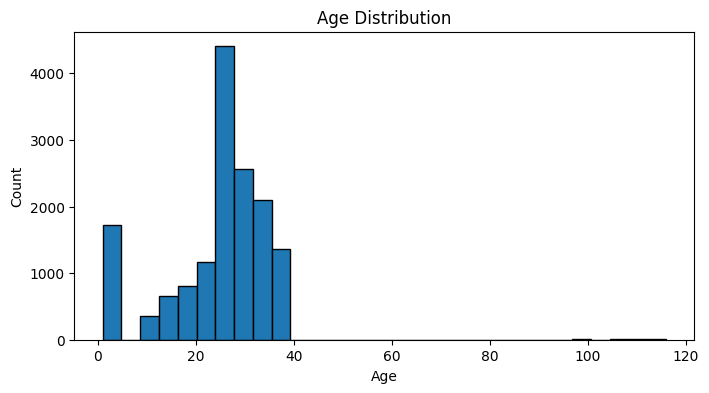

In [ ]:
plt.figure(figsize=(8,4))
plt.hist(df['age'], bins=30, edgecolor='black')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

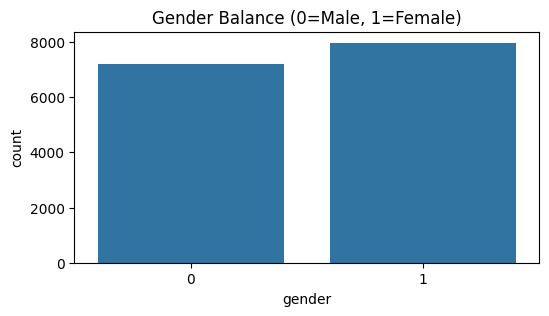

In [ ]:
plt.figure(figsize=(6,3))
sns.countplot(x='gender', data=df)
plt.title('Gender Balance (0=Male, 1=Female)')
plt.show()

Visualize Samples

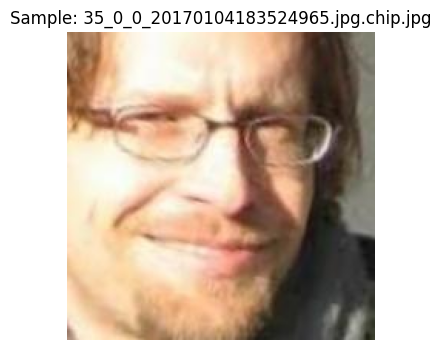

In [ ]:
sample_file = random.choice(df['file'].tolist())
img = Image.open(sample_file)
plt.figure(figsize=(4,4))
plt.imshow(img)
plt.axis('off')
plt.title(f"Sample: {os.path.basename(sample_file)}")
plt.show()

Configure Environment

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model

AUTOTUNE = tf.data.AUTOTUNE
IMG_SIZE = 64
BATCH_SIZE = 16
RANDOM_SEED = 42
tf.random.set_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

Split Data

In [ ]:
from sklearn.model_selection import train_test_split
df = df.dropna(subset=['file']).reset_index(drop=True)
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=RANDOM_SEED, stratify=df['gender'])
val_df, test_df  = train_test_split(temp_df, test_size=0.5, random_state=RANDOM_SEED, stratify=temp_df['gender'])

len(train_df), len(val_df), len(test_df)

(12132, 1516, 1517)

In [ ]:
from tensorflow.keras import layers, Model, optimizers, callbacks

In [ ]:
def preprocess_image_small(path, img_size=IMG_SIZE, training=False):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, [img_size, img_size])
    if training:
        img = tf.image.random_flip_left_right(img)
    return img

def make_dataset(df_in, batch_size=BATCH_SIZE, training=False, shuffle=True):
    paths = df_in['file'].values
    genders = df_in['gender'].astype('float32').values
    ages = df_in['age'].astype('float32').values
    ds = tf.data.Dataset.from_tensor_slices((paths, genders, ages))
    if shuffle and training:
        ds = ds.shuffle(buffer_size=min(len(paths), 2000))
    def _map(path, g, a):
        img = preprocess_image_small(path, img_size=IMG_SIZE, training=training)
        # NOTE: keys must match the model output names exactly
        labels = {'gender_output': tf.expand_dims(g, -1),
                  'age_output'   : tf.expand_dims(a, -1)}
        return img, labels
    ds = ds.map(_map, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

train_ds = make_dataset(train_df, training=True, shuffle=True)
val_ds   = make_dataset(val_df, training=False, shuffle=False)
test_ds  = make_dataset(test_df, training=False, shuffle=False)



In [ ]:
# --- 2) Multi-output CNN model (shared backbone + two heads) ---
def build_multitask_cnn(img_size=IMG_SIZE):
    inp = layers.Input(shape=(img_size, img_size, 3), name='image_input')
    # small conv backbone (you can swap for MobileNetV2 if GPU allows)
    x = layers.Conv2D(32, 3, padding='same', activation='relu')(inp)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool2D()(x)

    x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool2D()(x)
    x = layers.Dropout(0.25)(x)

    x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool2D()(x)
    x = layers.Dropout(0.25)(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.4)(x)

    # Gender head (binary)
    g = layers.Dense(64, activation='relu')(x)
    g = layers.Dropout(0.2)(g)
    gender_out = layers.Dense(1, activation='sigmoid', name='gender_output')(g)

    # Age head (regression)
    a = layers.Dense(128, activation='relu')(x)
    a = layers.Dropout(0.2)(a)
    age_out = layers.Dense(1, activation='linear', name='age_output')(a)

    model = Model(inputs=inp, outputs=[gender_out, age_out])
    return model

model = build_multitask_cnn(IMG_SIZE)
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 64, 64,    │        896 │ image_input[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        128 │ conv2d_15[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_15    │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 32, 32,    │     18,496 │ max_pooling2d_15… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_16[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_16    │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_25          │ (None, 16, 16,    │          0 │ max_pooling2d_16… │
│ (Dropout)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 16, 16,    │     73,856 │ dropout_25[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        512 │ conv2d_17[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_17    │ (None, 8, 8, 128) │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_26          │ (None, 8, 8, 128) │          0 │ max_pooling2d_17… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ dropout_26[0][0]  │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 256)       │     33,024 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_15[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_27          │ (None, 256)       │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 64)        │     16,448 │ dropout_27[0][0]  │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 177,730 (694.26 KB)

 Trainable params: 176,770 (690.51 KB)

 Non-trainable params: 960 (3.75 KB)

In [ ]:
model.compile(
    optimizer=optimizers.Adam(1e-3),
    loss={'gender_output': 'binary_crossentropy', 'age_output': 'mean_absolute_error'},
    loss_weights={'gender_output': 1.0, 'age_output': 1.0},
    metrics={'gender_output': ['accuracy'], 'age_output': [tf.keras.metrics.MeanAbsoluteError(name='mae')]}
)

In [ ]:
ckpt = callbacks.ModelCheckpoint(
    'tmp_multi_best.h5',
    save_best_only=True,
    monitor='val_gender_output_accuracy',
    mode='max',
    verbose=1
)

es = callbacks.EarlyStopping(
    monitor='val_gender_output_accuracy',
    patience=3,
    mode='max',
    restore_best_weights=True,
    verbose=1)


In [ ]:
for imgs, labels in train_ds.take(1):
    print("images shape:", imgs.shape)                     # (batch, IMG_SIZE, IMG_SIZE, 3)
    print("label keys:", list(labels.keys()))              # should be ['gender_output','age_output']
    print("gender shape:", labels['gender_output'].shape)  # (batch,1)
    print("age shape:", labels['age_output'].shape)        # (batch,1)
    print("gender sample values:", labels['gender_output'][:8].numpy().ravel())
    print("age sample values:", labels['age_output'][:8].numpy().ravel())
    break

In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=4,
    callbacks=[ckpt, es],
    verbose=1
)

Epoch 1/4
759/759 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - age_output_loss: 10.3327 - age_output_mae: 10.3327 - gender_output_accuracy: 0.5628 - gender_output_loss: 0.8007 - loss: 11.1335
Epoch 1: val_gender_output_accuracy improved from -inf to 0.61016, saving model to tmp_multi_best.h5


759/759 ━━━━━━━━━━━━━━━━━━━━ 220s 283ms/step - age_output_loss: 10.3303 - age_output_mae: 10.3303 - gender_output_accuracy: 0.5628 - gender_output_loss: 0.8006 - loss: 11.1309 - val_age_output_loss: 6.7399 - val_age_output_mae: 6.7361 - val_gender_output_accuracy: 0.6102 - val_gender_output_loss: 0.6455 - val_loss: 7.3816
Epoch 2/4
759/759 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - age_output_loss: 7.1519 - age_output_mae: 7.1519 - gender_output_accuracy: 0.6184 - gender_output_loss: 0.6534 - loss: 7.8053
Epoch 2: val_gender_output_accuracy improved from 0.61016 to 0.65106, saving model to tmp_multi_best.h5


759/759 ━━━━━━━━━━━━━━━━━━━━ 208s 274ms/step - age_output_loss: 7.1517 - age_output_mae: 7.1517 - gender_output_accuracy: 0.6184 - gender_output_loss: 0.6534 - loss: 7.8051 - val_age_output_loss: 5.9141 - val_age_output_mae: 5.9091 - val_gender_output_accuracy: 0.6511 - val_gender_output_loss: 0.6190 - val_loss: 6.5282
Epoch 3/4
759/759 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - age_output_loss: 6.3546 - age_output_mae: 6.3546 - gender_output_accuracy: 0.6594 - gender_output_loss: 0.6117 - loss: 6.9663
Epoch 3: val_gender_output_accuracy did not improve from 0.65106
759/759 ━━━━━━━━━━━━━━━━━━━━ 259s 271ms/step - age_output_loss: 6.3545 - age_output_mae: 6.3545 - gender_output_accuracy: 0.6594 - gender_output_loss: 0.6117 - loss: 6.9662 - val_age_output_loss: 7.5869 - val_age_output_mae: 7.5882 - val_gender_output_accuracy: 0.5772 - val_gender_output_loss: 0.7249 - val_loss: 8.3133
Epoch 4/4
759/759 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - age_output_loss: 5.9010 - age_output_mae: 5.9010 - gender

In [ ]:
test_results = model.evaluate(test_ds, verbose=1)

95/95 ━━━━━━━━━━━━━━━━━━━━ 461s 5s/step - age_output_loss: 5.5076 - age_output_mae: 5.5076 - gender_output_accuracy: 0.6178 - gender_output_loss: 0.6438 - loss: 6.1514


In [ ]:
metrics_names = model.metrics_names
results_dict = dict(zip(metrics_names, test_results))

In [ ]:
print(model.metrics_names)

['loss', 'compile_metrics', 'gender_output_loss', 'age_output_loss']


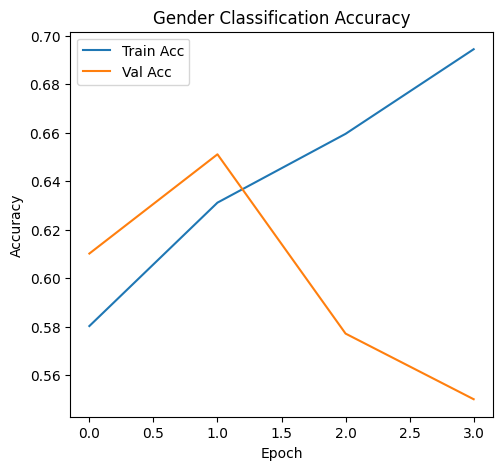

In [ ]:
plt.figure(figsize=(12, 5))

# Plot Gender Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['gender_output_accuracy'], label='Train Acc')
plt.plot(history.history['val_gender_output_accuracy'], label='Val Acc')
plt.title('Gender Classification Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

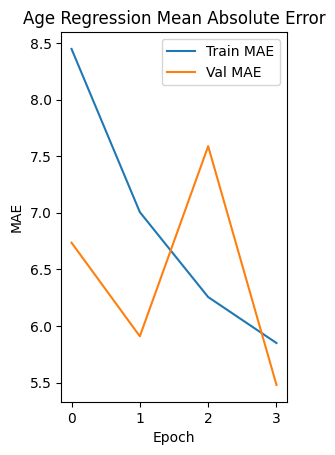

In [ ]:
plt.subplot(1, 2, 2)
plt.plot(history.history['age_output_mae'], label='Train MAE')
plt.plot(history.history['val_age_output_mae'], label='Val MAE')
plt.title('Age Regression Mean Absolute Error')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.show()

In [ ]:
y_pred_gender, y_pred_age = model.predict(test_ds)

95/95 ━━━━━━━━━━━━━━━━━━━━ 11s 109ms/step


In [ ]:
y_true_gender = test_df['gender'].values
y_true_age = test_df['age'].values

In [ ]:
y_pred_gender_class = (y_pred_gender > 0.5).astype(int).flatten()

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
classification_report(y_true_gender, y_pred_gender_class, target_names=['Male (0)', 'Female (1)'])

'              precision    recall  f1-score   support\n\n    Male (0)       0.57      0.89      0.70       720\n  Female (1)       0.80      0.40      0.53       797\n\n    accuracy                           0.63      1517\n   macro avg       0.69      0.64      0.61      1517\nweighted avg       0.69      0.63      0.61      1517\n'

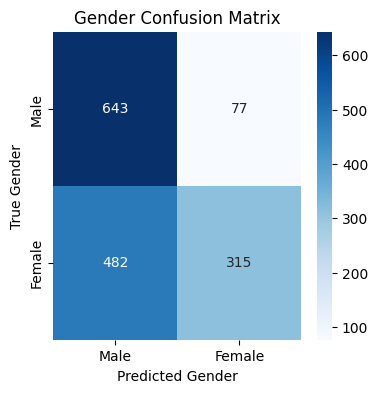

In [ ]:
cm = confusion_matrix(y_true_gender, y_pred_gender_class)
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Male', 'Female'], yticklabels=['Male', 'Female'])
plt.title('Gender Confusion Matrix')
plt.xlabel('Predicted Gender')
plt.ylabel('True Gender')
plt.show()